# Discretization API

`jaxdf` is built around the concept of discretization.

We define a **discretization family** as the mapping $\mathcal{D}$ that associates a function $f$ with a set of discrete parameters $\theta$:

$$
\theta \xrightarrow{\mathcal{D}}f
$$

where $f \in \text{Range}(\mathcal{D})$, or equivalently, $f_\theta(x) = \mathcal{D}(\theta, x)$ is a function parametrized by $\theta$.

Here, $\theta$ is the **discrete representation** of $f$ over $\mathcal{D}$. This is analogous to the interpolation function defined in other libraries (see, for example, the [Operator Discretization Library](https://odl.readthedocs.io)).

### Example

A simple example of a discretization family is the set of $N$-th order polynomials on the interval $[0,1)$: 

$$
\mathcal{P}_N(\theta,x) = \sum_{i=0}^N \theta_i x^i, \qquad \theta \in \mathbb{R}^{N+1}
$$

In `jaxdf`, we construct such a field using the `Continuous` discretization. To do so, we provide the function $\mathcal{P}_N$, the parameters of the function, and the domain where the function is defined.

In [1]:
from jaxdf.discretization import Continuous
from jaxdf.geometry import Domain
from jax.random import normal, PRNGKey
from jax import numpy as jnp

seed = PRNGKey(42)
N = 5

# This defines the spatial domain of the function
domain = Domain((256,),(1/64.,))

# This is the mapping from the parameters to the function
def p_n(theta, x):
    i = jnp.arange(N)
    powers = x**i
    return jnp.expand_dims(jnp.sum(theta*(x**i)), -1)

# Here we generate a random set of parameters
params = normal(seed, (N,))

# Finally, we place them all together in a single object
# that can be used to evaluate the function and apply operators
# to it.
u = Continuous(params, domain, p_n)

print(u)

Continuous(
  params=f32[5], domain=Domain(N=(256,), dx=(0.015625,)), get_fun=<function p_n>
)


Let's visualize the field over the domain using the `on_grid` method:

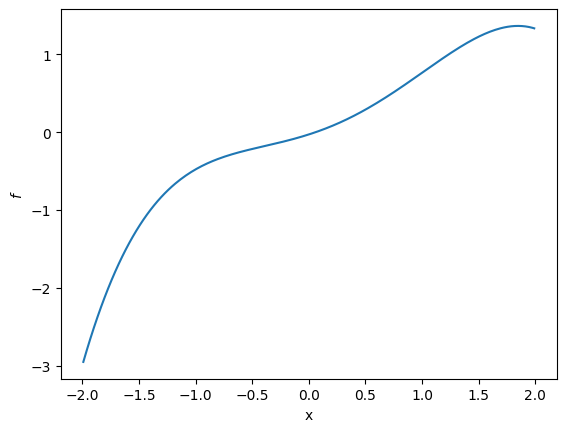

In [2]:
from matplotlib import pyplot as plt

def show_field(grid_representation, domain):
    plt.plot(domain.spatial_axis[0], grid_representation)
    plt.xlabel("x")
    plt.ylabel("$f$")
    plt.show()
    
field_on_grid = u.on_grid

show_field(field_on_grid, domain)

To evaluate the field at a specific location $x$, we can simply call the field at the required coordinates:

In [3]:
x = 1.2
field_at_x = u(x)
print(f"Field at x={x} : {field_at_x}")

Field at x=1.2 : [0.9661987]


Fields are pytrees based on [equinox](https://github.com/patrick-kidger/equinox) `Module`, so they natively work with `jax.jit`, `jax.grad`, etc.

Let's apply the derivative operator to this newly defined field:

In [4]:
from jaxdf.operators import derivative

du_dx = derivative(u)

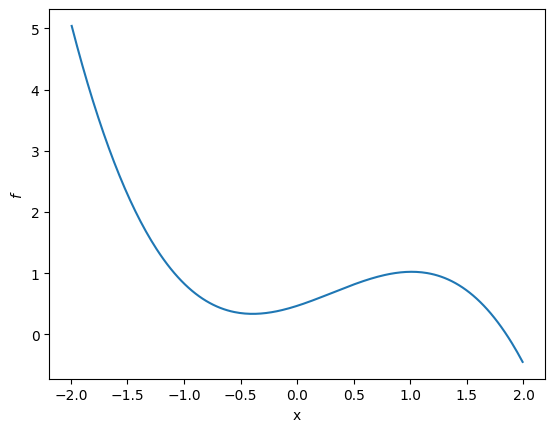

In [5]:
show_field(du_dx.on_grid, domain)

The parameters of the field `du_dx` are the same as `u`, since for `Continuous` fields the `gradient` operator is evaluated using autograd, which affects only the computational graph of the function but not its inputs.

In [6]:
u.θ, du_dx.θ # .θ is a shorthand for .params

(Array([-0.02830462,  0.46713185,  0.29570296,  0.15354592, -0.12403282],      dtype=float32),
 Array([-0.02830462,  0.46713185,  0.29570296,  0.15354592, -0.12403282],      dtype=float32))

## Customizing Discretizations

For a polynomial field, we actually know analytically how to compute derivatives:

$$
\frac{\partial}{\partial x}\mathcal{P}_N(\theta,x) = \frac{\partial}{\partial x} \sum_{i=0}^N \theta_i x^i = \sum_{i=0}^{N-1} i\theta_{i+1} x^i
$$

To leverage this knowledge, we first define a new discretization family from the `Continuous` class, and then define the `gradient` method using the analytical formula.

This new class needs to initialize the parent class using the `super().__init__()` method. The input parameters are `params`, `domain`, and `get_field`. However, we can use our knowledge of the formula for the `get_fun`.

The `params` must be a `PyTree` compatible with `jax.numpy` (arrays, dictionaries of arrays, equinox modules, etc.). The `domain` attribute must be a `jaxdf.geometry.Domain` object defining the domain of the field. The `get_field` attribute must be a function that evaluates the field at a coordinate using the parameters contained in `params`, with the signature `get_fun(params: Field.params, x: Union[jnp.ndarray, float])`.

In [7]:
class Polynomial(Continuous):
    @classmethod
    def from_params(cls, params, domain):
        
        def get_fun(params, x):
            i = jnp.arange(len(params))
            return jnp.expand_dims(jnp.sum(params*(x**i)), -1)
        
        return cls(
            params = params, 
            domain = domain, 
            get_fun = get_fun
        )
    
    @property
    def degree(self):
        return len(self.params)-1
    
    def __repr__(self):
        return "Polynomial(degree={})".format(self.degree)

Polynomial(degree=4) [-0.02830462  0.46713185  0.29570296  0.15354592 -0.12403282]


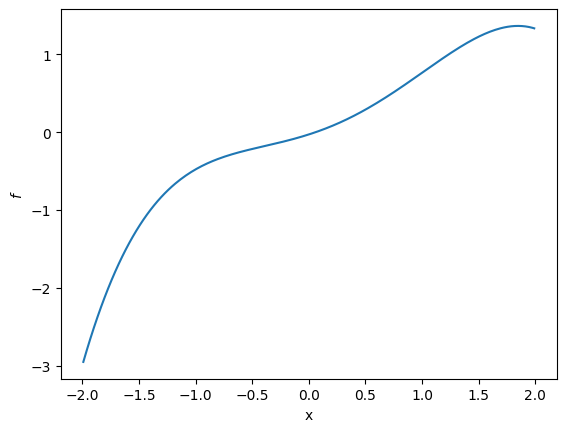

In [8]:
# Construct a polynomial field from the same parameters as before
u_custom = Polynomial.from_params(u.params, u.domain)

print(u_custom, u_custom.params)
show_field(u_custom.on_grid, domain)

To define the `derivative` operator acting on polynomials, we have several options. One is to simply define a Python function that generates the `Polynomial` object resulting from the gradient computation.

In [9]:
def derivative(u: Polynomial):
    # Find the parameters of the polynomial after differentiation
    coeffs = jnp.arange(1, u.params.shape[0])
    new_params = u.params[1:]*coeffs
    
    # Return a new polynomial with the new parameters
    return Polynomial.from_params(new_params, u.domain)

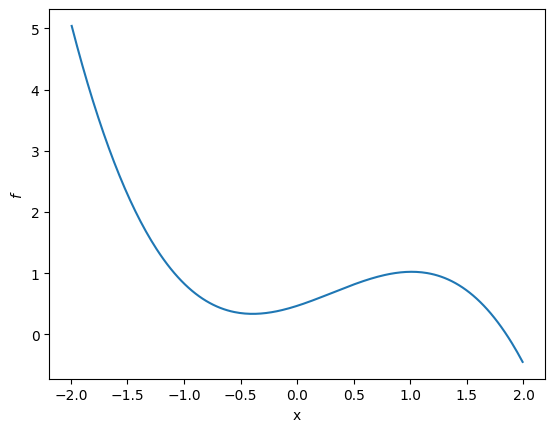

Polynomial(degree=3)


In [10]:
du_custom = derivative(u_custom)
show_field(du_custom.on_grid, domain)
print(du_custom)  # Note that the degree is one less than before

Note that the code is fully differentiable and can be compiled:

In [11]:
import jax

@jax.jit
def f(u):
    x = derivative(u) + 0.3
    return x(0.1)

print(f(u))

[0.8303827]


However, note that we now have a `derivative` operator defined for all types, and we get incorrect results for fields that are not polynomials:

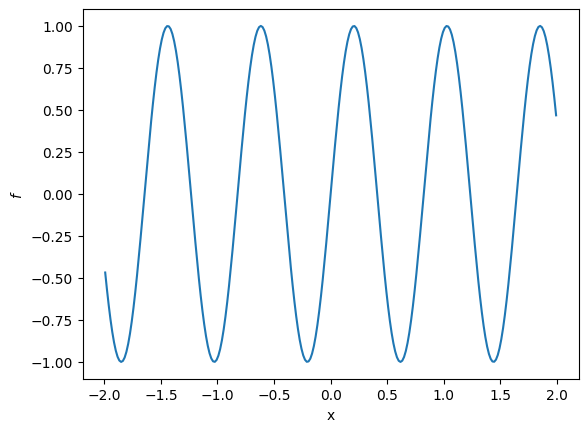

In [12]:
def sinfun(params, x):
    theta = jnp.sum(params) # dummy operation to make the parameter vector a scalar
    y = jnp.sin(theta*x*10)
    return y

params = u.params
sin = Continuous(params, domain, sinfun)
show_field(sin.on_grid, domain)

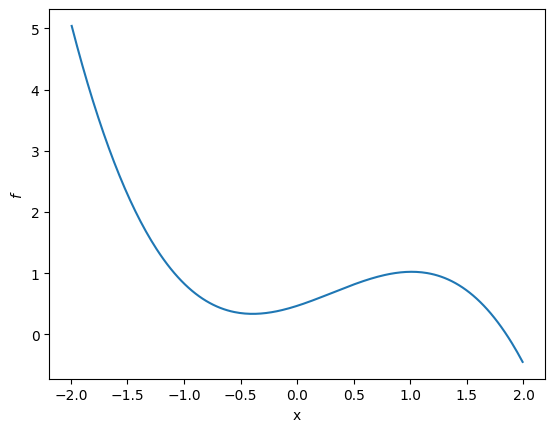

z:  Polynomial(degree=3)


In [13]:
z = derivative(sin)
show_field(z.on_grid, domain)
print('z: ', z)

### Operators and Multiple Dispatch

One way to avoid this is to implement operators as methods of the fields, which are then redefined by child classes. This was the approach used in `jaxdf` when it was first made public, and it can still be used.

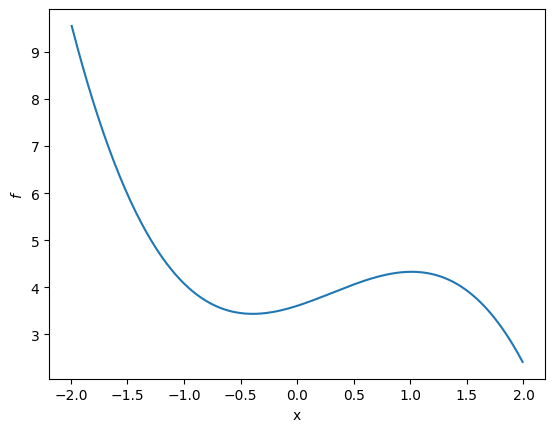

In [14]:
class PolynomialWithMethods(Polynomial):
    
    @classmethod
    def from_params(cls, params, domain):
        
        def get_fun(params, x):
            i = jnp.arange(len(params))
            return jnp.expand_dims(jnp.sum(params*(x**i)), -1)
        
        return cls(
            params = params, 
            domain = domain, 
            get_fun = get_fun
        )
    
    @property
    def degree(self):
        return len(self.params)-1
    
    def __repr__(self):
        return "Polynomial(degree={})".format(self.degree)
    
    # Custom derivative code, with parameters
    def derivative(self, exponent=1.0):
        new_params = self.params[1:]*jnp.arange(1, self.params.shape[0])*exponent
        return PolynomialWithMethods.from_params(new_params, self.domain)
    
@jax.jit
def g(u, exponent):
    return u.derivative(exponent) + 3.0

u_2 = PolynomialWithMethods.from_params(u.params, u.domain)

show_field(g(u_2, 1.3).on_grid, domain)

However, it can become cumbersome to manage many derived methods for different discretizations, especially when evaluating operators that accept multiple operands with different combinations of discretizations (e.g., dot products, `+`, heterogeneous differential operators, etc.).

This problem is elegantly resolved in some programming languages using *multiple dispatch*. One language that notably supports multiple dispatch is [Julia](https://docs.julialang.org/en/v1/manual/methods/), and I recommend looking at the packages in the [SciML ecosystem](https://sciml.ai/documentation/) if you are familiar with Julia or interested in learning it (those packages are excellent!).

For those sticking with Python, `jax`, and `jaxdf`, we borrow these ideas using the Python multiple dispatch library [plum](https://github.com/beartype/plum). The `jaxdf.operator` decorator can be used to define new (parametric) operators:
```python
@operator
def new_operator(x: Polynomial, y: Continuous, *, params=1.0):
    ... # Any jaxdf or jax-compatible code
    return Field(...)
```

The input of the function can be arbitrary types: if they are fields or any type traceable by jax, they will be traced. The function has a reserved, mandatory keyword argument `params`, which is used for the parameters of the operator, such as the coefficients of the stencil of a differential operator.

The output of the function can be any type, including `jaxdf.Field` or `jax.numpy.ndarray`.

The `@operator` decorator is most useful when arguments are defined using type annotations. This way, we leverage plum's dispatch method to define an implementation of that function specific to the annotated types.

In [15]:
from jaxdf import operator

@operator
def derivative(x: Polynomial, *, axis=None, params=None):
    print('Applying derivative to a polynomial')
    if axis is not None:
        print("Warning: axis argument is ignored for polynomials")
        
    new_params = x.params[1:]*jnp.arange(1, u.params.shape[0])
    return Polynomial.from_params(new_params, u.domain)

@operator
def derivative(x: Continuous, *, axis=0, params=None):
    print('Applying derivative to a generic Continuous field')
    get_x = x.get_fun
    def grad_fun(p, coords):
        f_jac = jax.jacfwd(get_x, argnums=(1,))
        return jnp.expand_dims(f_jac(p, coords)[0][0][axis], -1)
    return Continuous(x.params, x.domain, grad_fun)

Applying derivative to a polynomial


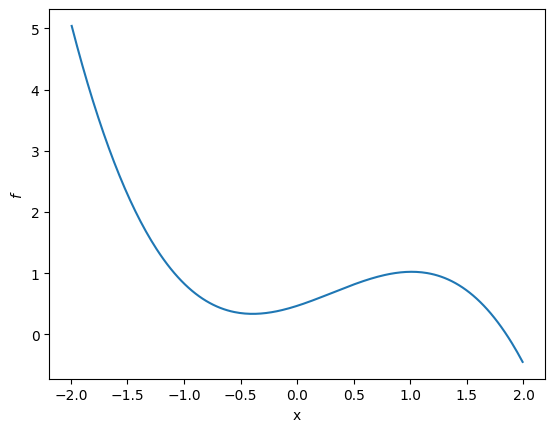

In [16]:
du_custom = derivative(u_custom)
show_field(du_custom.on_grid, domain)

Applying derivative to a generic Continuous field


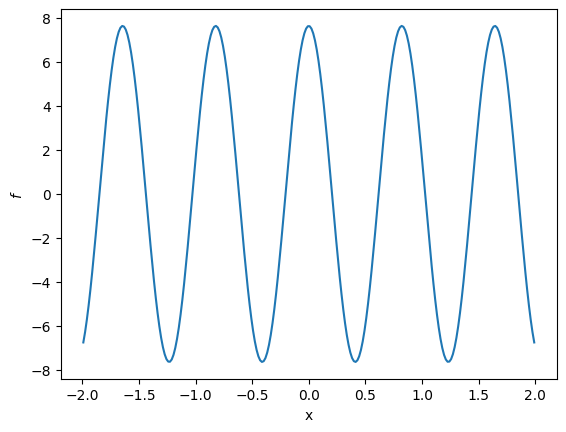

z:  Continuous(
  params=f32[5],
  domain=Domain(N=(256,), dx=(0.015625,)),
  get_fun=<function derivative.<locals>.grad_fun>
)


In [17]:
z = derivative(sin)

show_field(z.on_grid, domain)
print('z: ', z)